In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time
import numpy as np
import pandas as pd

# BESOS
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import (
    Parameter,
    RangeParameter,
    FieldSelector,
    expand_plist,
    wwr,
    CategoryParameter,
    GenericSelector
)
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Visualización
import matplotlib.pyplot as plt
from seaborn import heatmap, pairplot
from plotly import express as px

# Scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings

from epw import epw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
building = ef.get_building("lab_building.idf")
epw_file='Torino_IT-hour.epw'

In [4]:
meteo = epw()
meteo.read(epw_file)
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,15.800034,7.221598,58.167466,98690.003995,306.913584,...,99999.0,9.0,999999999.0,17.553311,0.174258,0.001826,74.213014,0.200115,0.082500,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,7.638139,7.427315,13.753316,291.739324,391.724168,...,0.0,0.0,0.0,9.051735,0.060578,0.042701,26.073199,0.002380,0.592314,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,-0.800000,-12.900000,27.000000,97687.000000,0.000000,...,99999.0,9.0,999999999.0,4.000000,0.039000,0.000000,0.000000,0.200000,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,9.700000,1.100000,47.000000,98469.000000,0.000000,...,99999.0,9.0,999999999.0,10.000000,0.126000,0.000000,76.000000,0.200000,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,15.700000,7.400000,57.000000,98731.000000,18.000000,...,99999.0,9.0,999999999.0,16.000000,0.181000,0.000000,88.000000,0.200000,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,22.000000,13.200000,68.000000,98909.250000,590.000000,...,99999.0,9.0,999999999.0,23.000000,0.218000,0.000000,88.000000,0.200000,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,34.300000,25.700000,100.000000,99260.000000,1229.000000,...,99999.0,9.0,999999999.0,56.000000,0.338000,1.000000,88.000000,0.266000,14.000000,99.0


In [5]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='MW Glass Wool (rolls)_.1445',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='EPS Expanded Polystyrene (Heavyweight)_.1', 
                         field_name='Thickness')

wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.1,max_val=0.8)


insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]

In [6]:
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))

In [7]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=5,max_val=20)

lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [8]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 30, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [9]:
windows = FieldSelector(class_name='FenestrationSurface:Detailed', 
                        object_name='*',
                        field_name='Construction Name')

win_arr = ['single_glazing','double_glazing','triple_glazing']
windowsTypes = CategoryParameter(win_arr)

windowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, 
                                           value_descriptors = windowsTypes, 
                                           name='Windows types'))

In [10]:
parameters = insulation_param + windowsParameters + [lights_param] + ventilationAchParam + setpointParams 

In [12]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Windows types',
 'Lights Watts/Area',
 'Ventilation ACH',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [13]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)

In [14]:
initial_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=20) #Creates 20 samples to be evaluated with EnergyPlus, these are going to
#be te 20 initial points for the FuzzyLolaVoronoi sampler from Harlow

In [15]:
t1 = time.time()
# Run Energyplus
initial_samples = evaluator.df_apply(initial_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/20 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running Ener

In [16]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  2 min 46 seconds


In [20]:
initial_samples.to_pickle("simulation_initial_points_example_6_20.pkl")

input_cols = [
    "Wall Insulation", "Roof Insulation", "Windows types", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

for i,win in enumerate(win_arr):
    initial_samples['Windows types'] = initial_samples['Windows types'].replace(win,i+1)

In [21]:
initial_points_x = initial_samples[input_cols].values.astype(float)  
initial_points_y = initial_samples[output_cols].values.astype(float)  

In [22]:
test_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=5) 

In [23]:
t1 = time.time()
# Run Energyplus
test_samples = evaluator.df_apply(test_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/5 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [24]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  0 min 42 seconds


In [27]:
for i,win in enumerate(win_arr):
    test_samples['Windows types'] = test_samples['Windows types'].replace(win,i+1)

test_samples.to_pickle("simulation_test_points_example_6_5.pkl")

test_x = test_samples[input_cols].values.astype(float)
test_y = test_samples[output_cols].values.astype(float)

In [28]:
#this is the first scaling, this is needed in order for harlow to work

scaler = StandardScaler()
initial_points_x_scale = scaler.fit_transform(X=initial_points_x)
test_x_scale = scaler.transform(X=test_x)

scaler_out = StandardScaler()
initial_points_y_scale = scaler_out.fit_transform(X=initial_points_y)
test_y_scale = scaler_out.transform(X=test_y)

In [47]:
# this are the bounds for harlow, please verify that are the same and in the same order as the parameters you created with besos
import numpy as np

# Bounds originales
domain_lower_bound = np.array([0.1,  0.1, 1, 5,  0.0, 18,  80], dtype=float)
domain_upper_bound = np.array([0.5,  0.8, 3, 20, 6.0, 30, 300], dtype=float)

# Scaling bounds is also necessary, use the same scaler that you used for the inputs in tis case "scaler"
scaled_lower_bound = scaler.transform(domain_lower_bound.reshape(1, -1)).ravel()
scaled_upper_bound = scaler.transform(domain_upper_bound.reshape(1, -1)).ravel()

print("Scaled lower bounds:", scaled_lower_bound)
print("Scaled upper bounds:", scaled_upper_bound)

Scaled lower bounds: [-1.72270104 -1.74486825 -1.19522861 -1.72785814 -1.73386388 -1.73325132
 -1.0675832 ]
Scaled upper bounds: [1.72690433 1.72564772 1.19522861 1.72952274 1.74622142 1.71339305
 1.69188699]


In [48]:
input_cols  = list(initial_points_x.columns)  if hasattr(initial_points_x, 'columns')  else [f'x{i}' for i in range(initial_points_x.shape[1])]
output_cols = list(initial_points_y.columns)  if hasattr(initial_points_y, 'columns') else ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

def target_f(x):
    """
    This function is the most important part when coupling EnergyPlus BESOS evaluator for it to work with Harlow.
    It takes the new point generated by Harlow in each adaptive iteration, descales it, reshapes it to the form 
    the evaluator needs, performs the evaluation, and returns the scaled output.
    """
    import numpy as np
    import pandas as pd

    # 1) Reshape to a numpy 2D
    x_arr = np.array(x, dtype=float)
    if x_arr.ndim == 1:
        x_arr = x_arr.reshape(1, -1)

    # 2) Descaling to original values
    x_orig = scaler.inverse_transform(x_arr)

    # 3) Determine glazing type (DO NOT modify the float array directly)
    glazing_value = x_orig[0][2]
    if glazing_value < 1.5:
        glazing_type = "single_glazing"
    elif glazing_value < 2.5:
        glazing_type = "double_glazing"
    else:
        glazing_type = "triple_glazing"

    # 4) Build the DataFrame for evaluator
    x_orig_list = x_orig.tolist()
    x_orig_list[0][2] = glazing_type  # Now safe to assign string in list
    df_in = pd.DataFrame(x_orig_list, columns=input_cols)

    # 5) Evaluate
    df_out = evaluator.df_apply(df_in)
    y_orig = df_out[output_cols].values.astype(float)

    # 6) Scaling the output again for Harlow
    y_scaled = scaler_out.transform(y_orig)

    return y_scaled


In [49]:
#necessary inputs from harlow for this example we will employ 
#LolaVoronoi sampler
#BatchIndependentGaussianProcess surrogate for estimating loss and new better points

import os
import numpy as np
from harlow.surrogating.surrogate_model import BatchIndependentGaussianProcess
from harlow.sampling import FuzzyLolaVoronoi

# Defining a custom RMSE for multi output, used for stopping criteria
def rmse_multi(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))

surrogate_model = BatchIndependentGaussianProcess

# Initializing the adaptive sampler
adaptive_samples = FuzzyLolaVoronoi(
    target_function    = target_f,
    surrogate_model    = surrogate_model,
    domain_lower_bound = scaled_lower_bound,
    domain_upper_bound = scaled_upper_bound,
    fit_points_x       = initial_points_x_scale,
    fit_points_y       = initial_points_y_scale,
    test_points_x      = test_x_scale,
    test_points_y      = test_y_scale,
    evaluation_metric  = rmse_multi
)

# patch for obtaining a 2D array
_orig_update = adaptive_samples.surrogate_model.update

def _update_force2d(X, y, **kwargs):
    y_arr = np.array(y, dtype=float)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(1, -1)
    return _orig_update(X, y_arr, **kwargs)
adaptive_samples.surrogate_model.update = _update_force2d

# Executes adaptive sampling
adaptive_samples.sample(
    n_initial_points           = initial_points_x.shape[0],
    max_n_iterations           = 20,
    n_new_points_per_iteration = 1,
    stopping_criterium         = [0.01]
)

Iter = 99 / 100, Loss = 0.8268043398857117, Loss_ratio = None

2025-05-26 19:43:45.109 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:126 - Fitted the first surrogate model in 0.3378620147705078 sec.
2025-05-26 19:43:45.114 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 1 (max steps: 20).


Iter = 100, Loss = 0.8268043398857117, Loss_ratio = None


2025-05-26 19:43:45.211 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.09595394134521484 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8261454701423645, Loss_ratio = None

2025-05-26 19:43:53.683 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.289172887802124 sec.
2025-05-26 19:43:53.693 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 2 (max steps: 20).


Iter = 100, Loss = 0.8261454701423645, Loss_ratio = None


2025-05-26 19:43:53.792 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.09968113899230957 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8346700072288513, Loss_ratio = None

2025-05-26 19:44:02.174 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.28978800773620605 sec.
2025-05-26 19:44:02.179 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 3 (max steps: 20).


Iter = 100, Loss = 0.8346700072288513, Loss_ratio = None


2025-05-26 19:44:02.294 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.11321735382080078 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8307893872261047, Loss_ratio = None

2025-05-26 19:44:11.064 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.27510595321655273 sec.
2025-05-26 19:44:11.071 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 4 (max steps: 20).


Iter = 100, Loss = 0.8307893872261047, Loss_ratio = None


2025-05-26 19:44:11.187 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.11640787124633789 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8052828907966614, Loss_ratio = None

2025-05-26 19:44:19.860 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2853105068206787 sec.
2025-05-26 19:44:19.866 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 5 (max steps: 20).


Iter = 100, Loss = 0.8052828907966614, Loss_ratio = None


2025-05-26 19:44:19.975 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.10783147811889648 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7868749499320984, Loss_ratio = None

2025-05-26 19:44:28.700 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2775871753692627 sec.
2025-05-26 19:44:28.706 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 6 (max steps: 20).


Iter = 100, Loss = 0.7868749499320984, Loss_ratio = None


2025-05-26 19:44:28.834 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.12756943702697754 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.767405092716217, Loss_ratio = Nonee

2025-05-26 19:44:37.366 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.301532506942749 sec.
2025-05-26 19:44:37.372 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 7 (max steps: 20).


Iter = 100, Loss = 0.767405092716217, Loss_ratio = None


2025-05-26 19:44:37.500 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.12649941444396973 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7826487421989441, Loss_ratio = None

2025-05-26 19:44:46.258 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2957732677459717 sec.
2025-05-26 19:44:46.263 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 8 (max steps: 20).


Iter = 100, Loss = 0.7826487421989441, Loss_ratio = None


2025-05-26 19:44:46.396 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.13243961334228516 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.768561065196991, Loss_ratio = Nonee

2025-05-26 19:44:55.070 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.31600475311279297 sec.
2025-05-26 19:44:55.075 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 9 (max steps: 20).


Iter = 100, Loss = 0.768561065196991, Loss_ratio = None


2025-05-26 19:44:55.217 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.14165353775024414 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7433274984359741, Loss_ratio = None

2025-05-26 19:45:04.009 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.30834174156188965 sec.


Iter = 100, Loss = 0.7433274984359741, Loss_ratio = None


2025-05-26 19:45:04.014 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 10 (max steps: 20).
2025-05-26 19:45:04.152 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.13700246810913086 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7342404723167419, Loss_ratio = None

2025-05-26 19:45:12.788 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3073694705963135 sec.
2025-05-26 19:45:12.794 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 11 (max steps: 20).


Iter = 100, Loss = 0.7342404723167419, Loss_ratio = None


2025-05-26 19:45:12.957 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.16250395774841309 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7901114225387573, Loss_ratio = None

2025-05-26 19:45:21.855 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.30178356170654297 sec.
2025-05-26 19:45:21.860 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 12 (max steps: 20).


Iter = 100, Loss = 0.7901114225387573, Loss_ratio = None


2025-05-26 19:45:22.036 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.17540287971496582 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7735781669616699, Loss_ratio = None

2025-05-26 19:45:30.718 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3294699192047119 sec.
2025-05-26 19:45:30.724 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 13 (max steps: 20).


Iter = 100, Loss = 0.7735781669616699, Loss_ratio = None


2025-05-26 19:45:30.890 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.16476655006408691 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7514808773994446, Loss_ratio = None

2025-05-26 19:45:39.639 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29972147941589355 sec.
2025-05-26 19:45:39.644 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 14 (max steps: 20).


Iter = 100, Loss = 0.7514808773994446, Loss_ratio = None


2025-05-26 19:45:39.852 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2062678337097168 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7297574281692505, Loss_ratio = None

2025-05-26 19:45:48.811 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3305332660675049 sec.
2025-05-26 19:45:48.818 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 15 (max steps: 20).


Iter = 100, Loss = 0.7297574281692505, Loss_ratio = None


2025-05-26 19:45:49.023 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.20470929145812988 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7580863833427429, Loss_ratio = None

2025-05-26 19:45:57.642 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.33099818229675293 sec.
2025-05-26 19:45:57.650 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 16 (max steps: 20).


Iter = 100, Loss = 0.7580863833427429, Loss_ratio = None


2025-05-26 19:45:57.853 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.20357728004455566 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7488217949867249, Loss_ratio = None

2025-05-26 19:46:06.265 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.33540892601013184 sec.
2025-05-26 19:46:06.271 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 17 (max steps: 20).


Iter = 100, Loss = 0.7488217949867249, Loss_ratio = None


2025-05-26 19:46:06.482 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.20994901657104492 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7231650352478027, Loss_ratio = None

2025-05-26 19:46:15.793 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.32593202590942383 sec.
2025-05-26 19:46:15.800 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 18 (max steps: 20).


Iter = 100, Loss = 0.7231650352478027, Loss_ratio = None


2025-05-26 19:46:16.008 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2072160243988037 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7001172304153442, Loss_ratio = None

2025-05-26 19:46:24.725 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.35048866271972656 sec.
2025-05-26 19:46:24.730 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 19 (max steps: 20).


Iter = 100, Loss = 0.7001172304153442, Loss_ratio = None


2025-05-26 19:46:24.962 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2307572364807129 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6744146347045898, Loss_ratio = None

2025-05-26 19:46:33.961 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3167273998260498 sec.
2025-05-26 19:46:33.970 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 20 (max steps: 20).


Iter = 100, Loss = 0.6744146347045898, Loss_ratio = None


2025-05-26 19:46:34.226 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2549479007720947 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6548499464988708, Loss_ratio = None

2025-05-26 19:46:43.214 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.384002685546875 sec.


Iter = 100, Loss = 0.6548499464988708, Loss_ratio = None


(array([[-1.13001265e+00,  4.14651984e-01, -1.19522861e+00,
          8.13148834e-01,  1.20254206e+00, -5.13135580e-01,
          1.39967324e+00],
        [ 1.07579228e+00,  1.20259291e+00,  1.19522861e+00,
          4.33976671e-01, -7.96317948e-01,  1.38969742e+00,
         -1.51188745e+00],
        [-2.75931183e-01, -5.81677078e-01, -1.19522861e+00,
         -1.06027676e+00, -6.79481314e-01,  4.11057908e-01,
         -6.99401090e-01],
        [ 5.91542346e-01, -6.24294881e-02,  0.00000000e+00,
          1.49334552e+00,  1.41763974e+00,  9.50535830e-01,
         -1.09716354e+00],
        [ 1.33116824e+00, -1.14196102e+00, -1.19522861e+00,
          1.02609155e+00,  1.07374665e-01, -5.69779436e-01,
         -2.29791001e-01],
        [ 5.10315983e-01, -1.57728433e+00, -1.19522861e+00,
         -1.60028696e+00, -1.47783304e+00, -1.49231210e+00,
         -1.33784099e+00],
        [ 1.47674937e+00, -1.40107051e+00,  1.19522861e+00,
         -8.05466223e-01, -1.10852550e-01,  1.26488941e+00

In [50]:
#first descaling of adaptive objects, we do this in order to see the real distribution of samples so here the vizualization of the data starts
input_cols = [
    "Wall Insulation", "Roof Insulation", "Windows types", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

X_adaptive = adaptive_samples.fit_points_x    
Y_adaptive = adaptive_samples.fit_points_y    

df_adaptive_samples = pd.DataFrame(X_adaptive, columns=input_cols)
for i, col in enumerate(output_cols):
    df_adaptive_samples[col] = Y_adaptive[:, i]

outputs = df_adaptive_samples.drop(input_cols, axis=1)
inputs = df_adaptive_samples.drop(objectives, axis=1)

outputs_original = scaler_out.inverse_transform(outputs)
inputs_original = scaler.inverse_transform(inputs)

outputs_original_df=pd.DataFrame(outputs_original, columns=objectives)
inputs_original_df=pd.DataFrame(inputs_original, columns=input_cols)

samples_original_df = pd.concat([inputs_original_df,outputs_original_df], axis=1)

In [51]:
samples_original_df.to_pickle("adaptive_samples_example_6_40.pkl") #saving the EP runs input - output rows(could save you a lot of time)

In [52]:
samples_original_df.describe()

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,4.000000e+01,4.000000e+01,4.000000e+01
mean,0.309432,0.470917,2.104651,11.457844,2.994443,24.012686,188.828411,7.758256e+09,9.125723e+09,7.679350e+09
std,0.131650,0.245943,0.771818,4.966364,1.945365,3.997499,82.207651,1.718329e+09,8.924197e+08,1.586003e+09
min,0.101529,0.101559,1.000000,5.135191,0.131137,18.152989,32.920838,5.544378e+09,7.783566e+09,5.149336e+09
25%,0.192795,0.210145,1.437153,6.180019,1.322799,20.283084,117.968413,5.930400e+09,8.419055e+09,6.344715e+09
50%,0.297074,0.473805,2.000000,10.663784,2.826936,24.594007,195.970417,7.544716e+09,9.003662e+09,7.478754e+09
75%,0.431903,0.701950,2.903453,16.255237,4.945322,27.698096,268.341927,9.386010e+09,9.590105e+09,8.858170e+09
max,0.495078,0.799767,3.000000,19.884577,5.978650,29.948662,299.974066,1.063322e+10,1.163101e+10,1.204272e+10


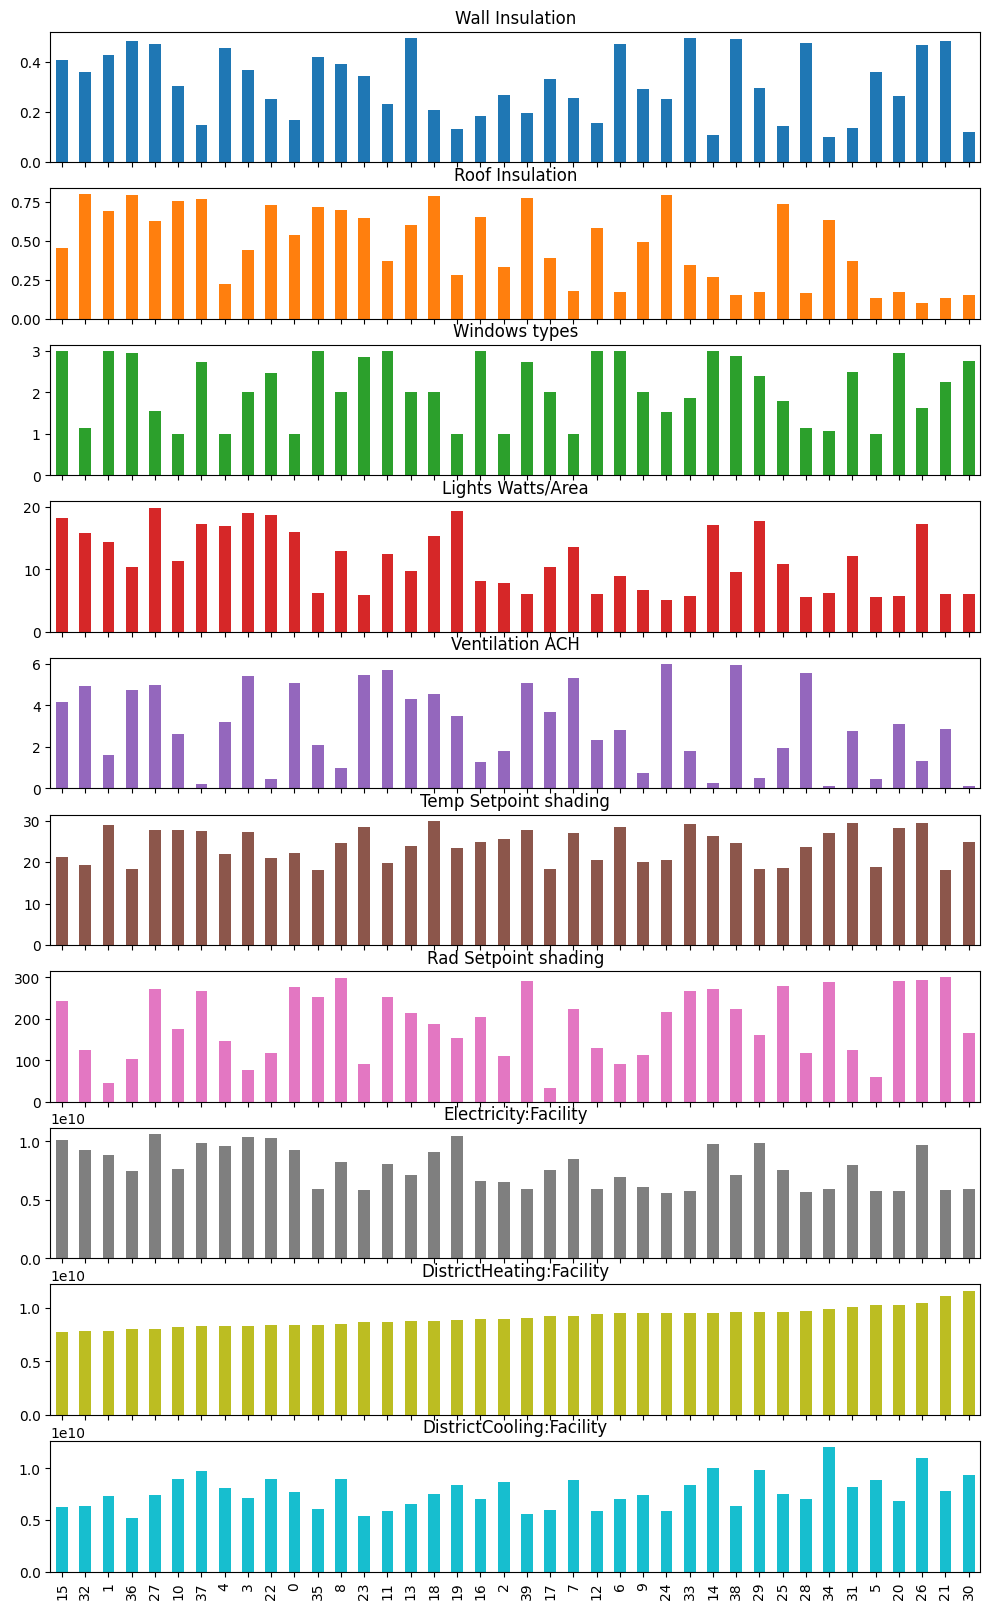

In [53]:
samples_original_df = samples_original_df.sort_values(by=output_cols[1])
ax=samples_original_df.plot.bar(subplots=True,legend=None, figsize=(12,20))

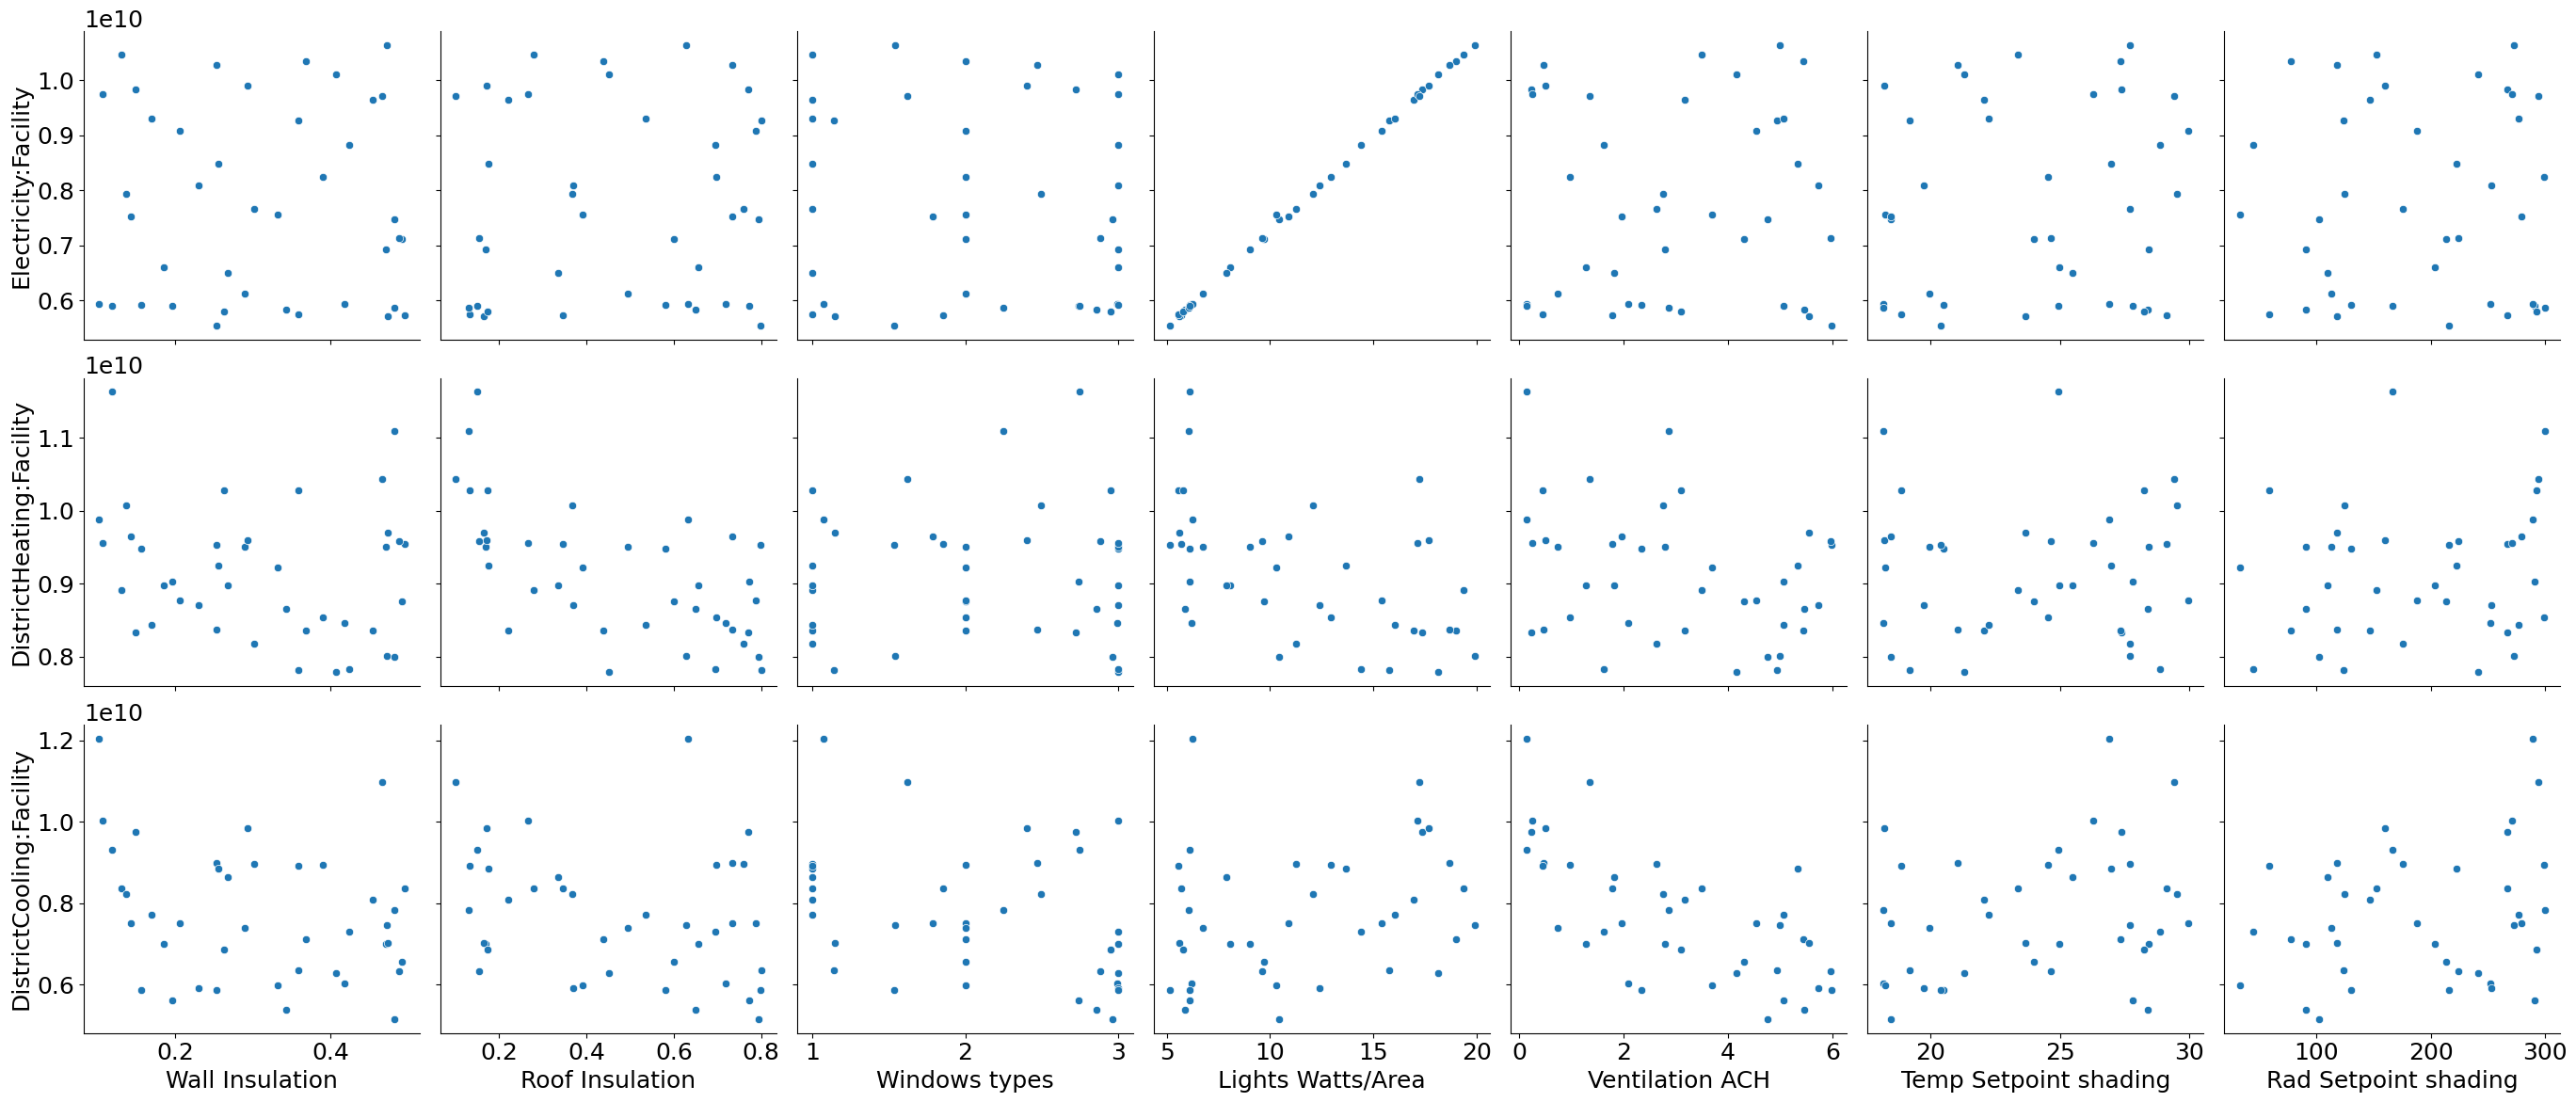

In [54]:
plt.rcParams.update({'font.size': 18})
_=pairplot(samples_original_df,x_vars=input_cols, y_vars=objectives, kind="scatter",height=4)

In [55]:
corr=samples_original_df.corr()
corr

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,-0.183340,-0.012309,-0.034695,0.286624,-0.063106,-0.133743,-0.033060,-0.188081,-0.288779
Roof Insulation,-0.183340,1.000000,0.090694,0.052124,0.091920,-0.036143,0.047736,0.052782,-0.629600,-0.291096
Windows types,-0.012309,0.090694,1.000000,-0.123086,-0.095742,0.034573,0.035684,-0.114099,0.016192,-0.375949
Lights Watts/Area,-0.034695,0.052124,-0.123086,1.000000,0.028586,0.097906,0.025817,0.999703,-0.506249,0.275517
Ventilation ACH,0.286624,0.091920,-0.095742,0.028586,1.000000,0.002796,-0.036616,0.027504,-0.323580,-0.685852
Temp Setpoint shading,-0.063106,-0.036143,0.034573,0.097906,0.002796,1.000000,0.136904,0.089348,0.012626,0.288285
Rad Setpoint shading,-0.133743,0.047736,0.035684,0.025817,-0.036616,0.136904,1.000000,0.013794,0.159229,0.249347
Electricity:Facility,-0.033060,0.052782,-0.114099,0.999703,0.027504,0.089348,0.013794,1.000000,-0.510082,0.267706
DistrictHeating:Facility,-0.188081,-0.629600,0.016192,-0.506249,-0.323580,0.012626,0.159229,-0.510082,1.000000,0.337463
DistrictCooling:Facility,-0.288779,-0.291096,-0.375949,0.275517,-0.685852,0.288285,0.249347,0.267706,0.337463,1.000000


In [56]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Windows types,-0.012309,0.090694,1.000000,-0.123086,-0.095742,0.034573,0.035684
Electricity:Facility,-0.033060,0.052782,-0.114099,0.999703,0.027504,0.089348,0.013794
DistrictHeating:Facility,-0.188081,-0.629600,0.016192,-0.506249,-0.323580,0.012626,0.159229
DistrictCooling:Facility,-0.288779,-0.291096,-0.375949,0.275517,-0.685852,0.288285,0.249347


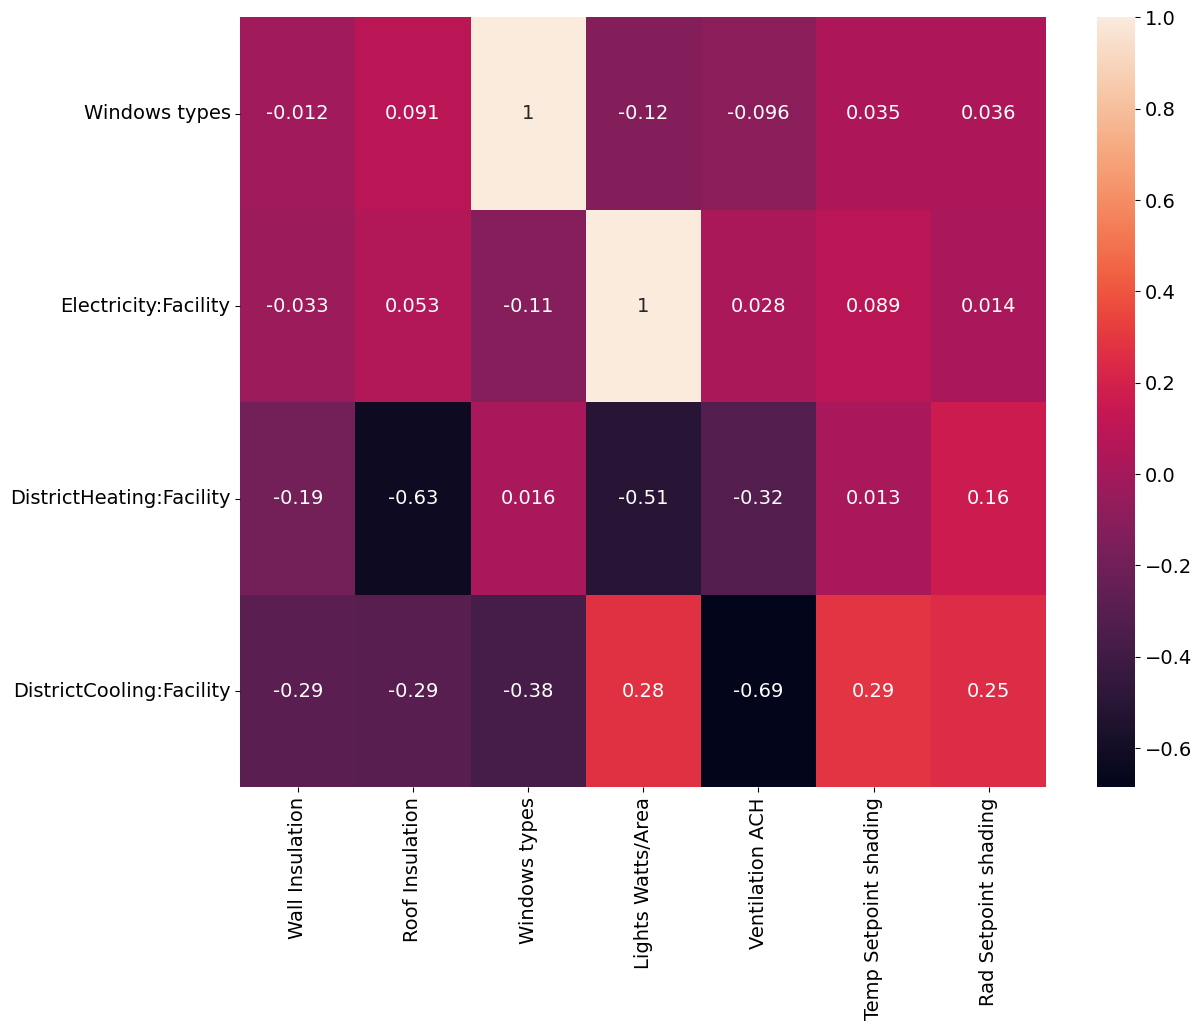

In [57]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [58]:
train_in, test_in, train_out, test_out = train_test_split(
    inputs_original_df, outputs_original_df, test_size=0.2
)

In [59]:
#second scaling we turn again the original samples in to scaled dataset to train and test surrogate models

scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [60]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

In [61]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [62]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,547 (17.76 KB)

 Trainable params: 4,547 (17.76 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [63]:
mse = mean_squared_error(prediction_gp,
                         test_out.values,
                         multioutput='raw_values')

# 2) RMSE
rmse = np.sqrt(mse)

mean_vals = test_out.mean().values
rmse_pct = rmse / mean_vals * 100


print("GP:")
print("RMSE:", rmse)
print("RMSE %:", rmse_pct)

GP:
RMSE: [1.09199079e+08 3.61863488e+08 6.64293283e+08]
RMSE %: [1.48854648 4.01227072 9.18157732]


In [64]:
mse_nn = mean_squared_error(
    prediction_nn,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_nn = np.sqrt(mse_nn)

mean_vals = test_out.mean().values
rmse_pct_nn = rmse_nn / mean_vals * 100

print("NN:")
print("RMSE NN:", rmse_nn)
print("RMSE % NN:", rmse_pct_nn)

NN:
RMSE NN: [1.98264441e+08 3.72825040e+08 5.98703625e+08]
RMSE % NN: [2.70264034 4.13381024 8.27502515]


In [65]:
mse_tf = mean_squared_error(
    prediction_tf,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_tf = np.sqrt(mse_tf)

mean_vals = test_out.mean().values
rmse_pct_tf = rmse_tf / mean_vals * 100


print("TF:")
print("RMSE TensorFlow:", rmse_tf)
print("RMSE % TensorFlow:", rmse_pct_tf)

TF:
RMSE TensorFlow: [5.90890293e+08 5.37491525e+08 7.34401518e+08]
RMSE % TensorFlow: [ 8.05471692  5.95959963 10.15058332]


In [66]:
parameters = insulation_param + [lights_param]  + ventilationAchParam + setpointParams

objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [67]:
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(best_gp.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

ValueError: could not convert string to float: 'double_glazing'

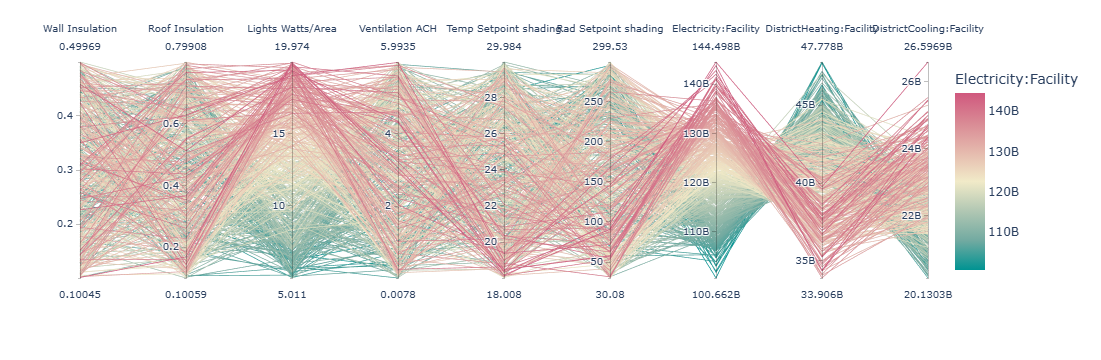

In [47]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

features = input_cols
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [48]:
from platypus import Problem, Real, NSGAII
import numpy as np

# 1) Número de variables y de objetivos
d = len(features)
m = len(objectives)

# 2) Monta el problema Platypus “a mano”
plat_prob = Problem(d, m)
plat_prob.types[:] = [
    Real(param.value_descriptor.min, param.value_descriptor.max)
    for param in parameters
]
plat_prob.function = lambda xs: tuple(evaluation_func(xs))

# 3) Corre NSGA-II
algo = NSGAII(plat_prob, population_size=10000)
algo.run(5000)

# 4) Saca tu frente Pareto
pareto = algo.result
objectives_array = np.array([sol.objectives for sol in pareto])

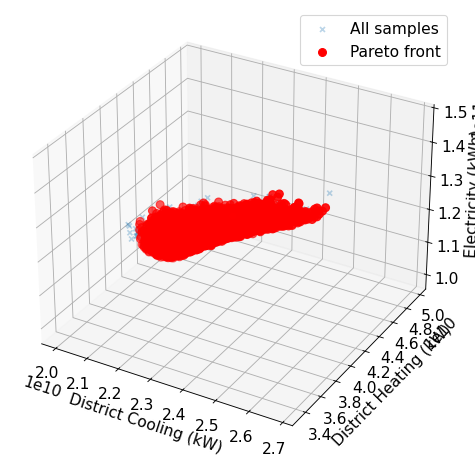

In [49]:
pareto_sols = algo.result
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])

# 2) Montar DataFrame de Pareto con las mismas columnas que srresults
opt_df = pd.DataFrame(
    np.hstack([X_pareto, Y_pareto]),
    columns=features + objectives
)

# 3) Graficar todo el muestreo inicial y el frente Pareto en 3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax  = fig.add_subplot(111, projection='3d')

# Muestreo inicial en azul con cruces
ax.scatter(
    srresults["DistrictCooling:Facility"],
    srresults["DistrictHeating:Facility"],
    srresults["Electricity:Facility"],
    marker='x', alpha=0.3, label='All samples'
)

# Frontera de Pareto en rojo con círculos
ax.scatter(
    opt_df["DistrictCooling:Facility"],
    opt_df["DistrictHeating:Facility"],
    opt_df["Electricity:Facility"],
    c='r', marker='o', s=50, label='Pareto front'
)

ax.set_xlabel("District Cooling (kW)")
ax.set_ylabel("District Heating (kW)")
ax.set_zlabel("Electricity (kWh)")
ax.legend()
plt.tight_layout()
plt.show()

In [50]:
opt_df

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.359197,0.582802,18.064603,4.688475,26.000730,164.628223,1.331248e+11,3.565703e+10,2.370258e+10
1,0.404220,0.711968,12.749105,5.713152,26.302922,49.774465,1.210871e+11,3.809941e+10,2.232418e+10
2,0.377185,0.519383,19.286750,4.219310,23.882371,222.093658,1.371093e+11,3.524207e+10,2.441624e+10
3,0.492884,0.243687,13.296006,5.632742,20.761113,216.965311,1.259497e+11,4.067909e+10,2.310901e+10
4,0.259136,0.740675,11.915150,4.972834,18.198140,179.163922,1.266618e+11,3.873471e+10,2.351182e+10
...,...,...,...,...,...,...,...,...,...
9995,0.264096,0.531540,7.023984,3.635417,20.892511,39.409705,1.117381e+11,4.270327e+10,2.207155e+10
9996,0.495967,0.146895,13.007017,3.577230,24.686798,204.609460,1.212668e+11,4.255205e+10,2.291852e+10
9997,0.104553,0.707465,10.146504,4.386240,20.104545,191.584446,1.232780e+11,4.078930e+10,2.343891e+10
9998,0.149368,0.458743,16.765667,0.177079,28.540877,153.113786,1.261124e+11,3.900539e+10,2.236433e+10


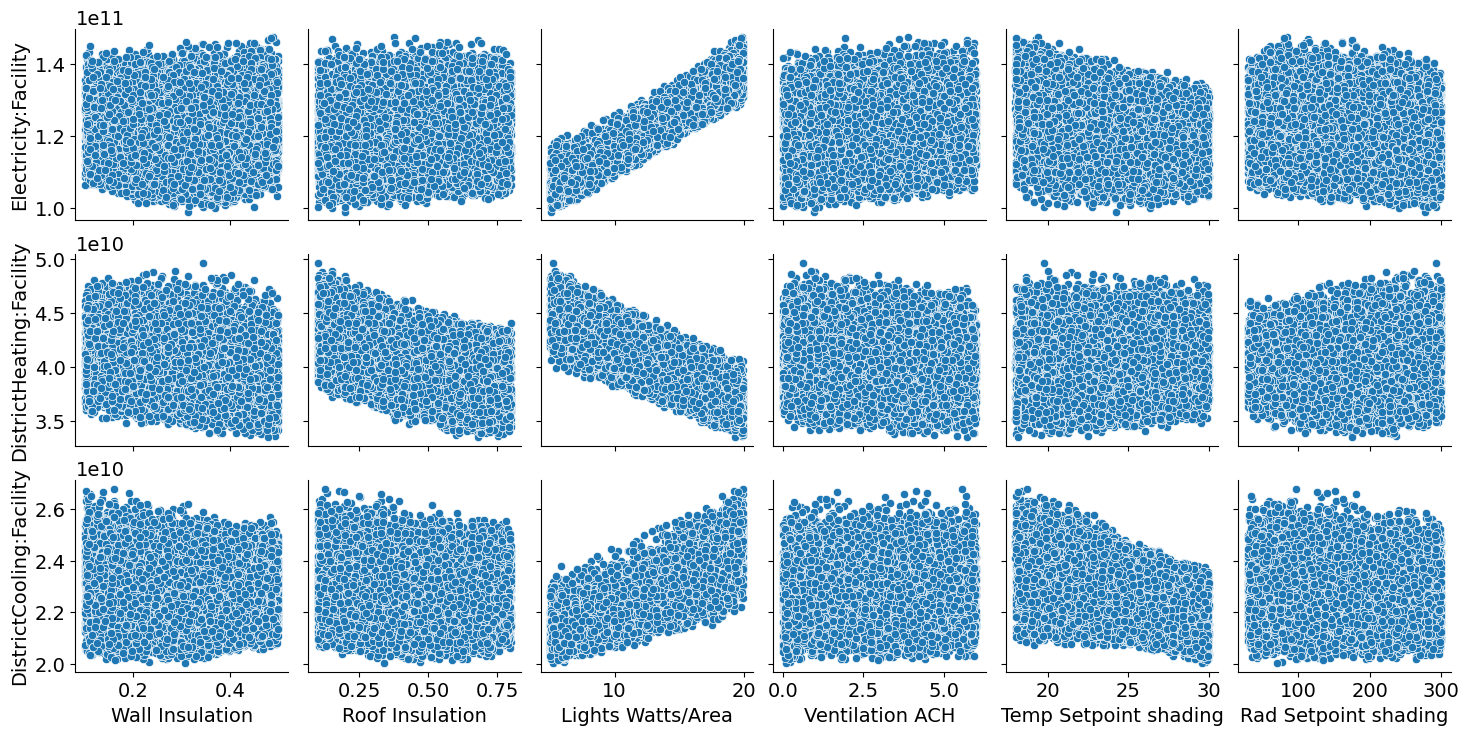

In [51]:
_=pairplot(opt_df,x_vars=input_cols, y_vars=objectives, kind="scatter")

In [52]:
pareto_sols = algo.result  # o NSGAII(...) según tu opción B
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])
opt_df = pd.DataFrame(np.hstack([X_pareto, Y_pareto]), columns=features + objectives)

In [53]:
corr=opt_df.corr()

corr.drop(objectives, axis = 1, inplace = True)
corr.drop(features, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,0.011385,0.069792,0.936524,0.118113,-0.225345,-0.077661
DistrictHeating:Facility,-0.172643,-0.492077,-0.826465,-0.113087,0.054321,0.080384
DistrictCooling:Facility,-0.088814,-0.055660,0.800473,0.025903,-0.487944,-0.072725


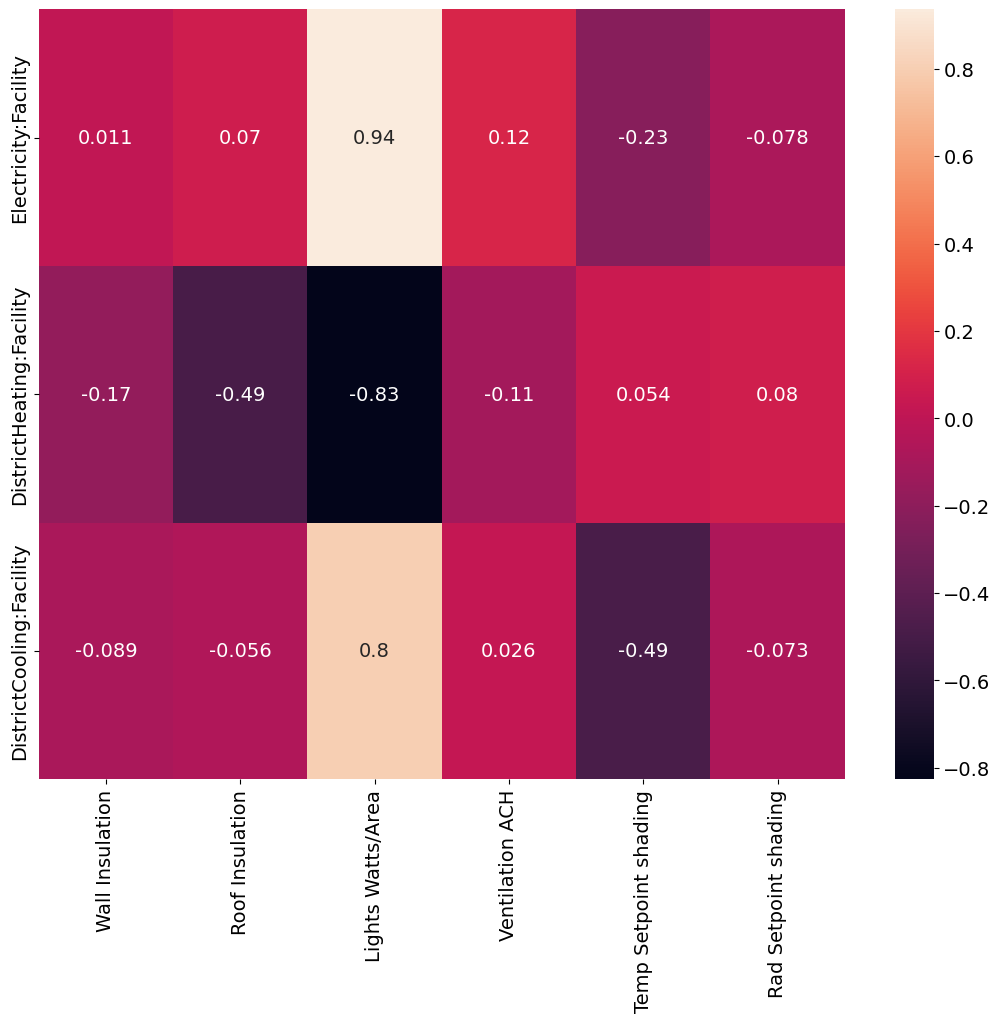

In [54]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [55]:
opt_df['Total'] = opt_df['Electricity:Facility'] + opt_df['DistrictHeating:Facility'] + opt_df['DistrictCooling:Facility']
opt_df['Dist'] = opt_df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

opt_df[opt_df.Dist == opt_df.Dist.min()]

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
1873,0.312081,0.199529,5.072746,0.979193,24.233847,276.921043,9.900849e+10,4.849670e+10,2.079485e+10,1.683000e+11,1.121920e+11


In [56]:
optimal_params=opt_df.loc[opt_df.Dist == opt_df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.3120814984996626,
 'Roof Insulation': 0.19952892208138046,
 'Lights Watts/Area': 5.072745643543747,
 'Ventilation ACH': 0.9791926748909341,
 'Temp Setpoint shading': 24.233847311788303,
 'Rad Setpoint shading': 276.92104269155345}